<a href="https://colab.research.google.com/github/Lakshaykumarr28/stocks-price-predictor/blob/main/stocks_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Introducing datasets.

In [176]:
adani_stocks = 'https://raw.githubusercontent.com/Lakshaykumarr28/Machine-Learning-using-Python/main/Adani%20Enterprises%20Limited.csv'
Microsoft_stocks = '/content/MSFT.csv'
Meta_stocks = '/content/META.csv'
dataset = pd.read_csv(Meta_stocks)
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,338.299988,341.079987,337.190002,338.540009,338.540009,14537900
1,2022-01-04,339.950012,343.089996,331.869995,336.529999,336.529999,15998000
2,2022-01-05,333.019989,335.760010,323.839996,324.170013,324.170013,20564500
3,2022-01-06,322.820007,339.170013,322.720001,332.459991,332.459991,27962800
4,2022-01-07,332.739990,337.000000,328.880005,331.790009,331.790009,14722000
...,...,...,...,...,...,...,...
405,2023-08-15,306.140015,307.230011,300.029999,301.950012,301.950012,11623600
406,2023-08-16,300.200012,301.079987,294.279999,294.290009,294.290009,18547700
407,2023-08-17,293.049988,296.049988,284.950012,285.089996,285.089996,23950100
408,2023-08-18,279.029999,285.690002,274.380005,283.250000,283.250000,34061200


# Creating DataFrame and preprocessing the data.

In [162]:
df = dataset[['Date', 'Close']]

df

,Date,Close
0,2022-01-03,338.540009
1,2022-01-04,336.529999
2,2022-01-05,324.170013
3,2022-01-06,332.459991
4,2022-01-07,331.790009
...,...,...
405,2023-08-15,301.950012
406,2023-08-16,294.290009
407,2023-08-17,285.089996
408,2023-08-18,283.250000


Making a function to change date type from 'object' to 'datetime'.

In [163]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

Applying the function on date column

In [164]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-164-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0     2022-01-03
1     2022-01-04
2     2022-01-05
3     2022-01-06
4     2022-01-07
         ...    
405   2023-08-15
406   2023-08-16
407   2023-08-17
408   2023-08-18
409   2023-08-21
Name: Date, Length: 410, dtype: datetime64[ns]

Changing the index to date.

In [165]:
df.index = df.pop('Date')
df

,Close
Date,
2022-01-03,338.540009
2022-01-04,336.529999
2022-01-05,324.170013
2022-01-06,332.459991
2022-01-07,331.790009
...,...
2023-08-15,301.950012
2023-08-16,294.290009
2023-08-17,285.089996


Plotting the value of stocks.

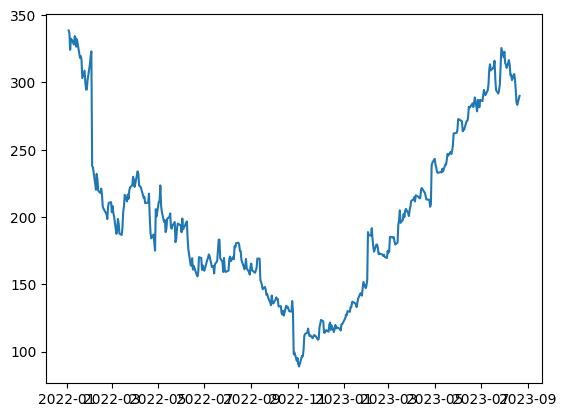

In [166]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

Creating a function to make windowed df that shows the relation between target date's stock's prices and stock prices three days before.

In [167]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

#use end date for MSFT : 2023-08-21
#use end date for adani stocks : 2023-08-22
windowed_df = df_to_windowed_df(df,
                                '2022-01-06',
                                '2023-08-21',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-01-06,338.540009,336.529999,324.170013,332.459991
1,2022-01-07,336.529999,324.170013,332.459991,331.790009
2,2022-01-10,324.170013,332.459991,331.790009,328.070007
3,2022-01-11,332.459991,331.790009,328.070007,334.369995
4,2022-01-12,331.790009,328.070007,334.369995,333.260010
...,...,...,...,...,...
402,2023-08-15,305.739990,301.640015,306.190002,301.950012
403,2023-08-16,301.640015,306.190002,301.950012,294.290009
404,2023-08-17,306.190002,301.950012,294.290009,285.089996
405,2023-08-18,301.950012,294.290009,285.089996,283.250000


Creating a function to get date, X, and Y values from windowed dataframe.

In [168]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((407,), (407, 3, 1), (407,))

# Splitting the dataset in training, validation and testing dataset and plotting it for visualisation.

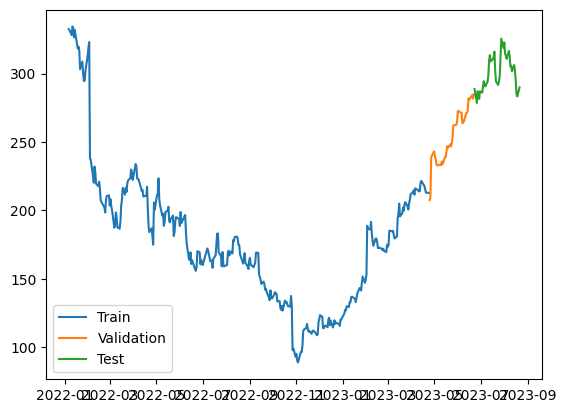

In [169]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Creating a LSTM neural network for price prediction.

In [170]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000)

Epoch 1/1000
11/11 [==============================] - 3s 66ms/step - loss: 34111.0312 - mean_absolute_error: 177.9171 - val_loss: 63298.2578 - val_mean_absolute_error: 250.8224
Epoch 2/1000
11/11 [==============================] - 0s 12ms/step - loss: 33191.9727 - mean_absolute_error: 175.2873 - val_loss: 61613.7031 - val_mean_absolute_error: 247.4422
Epoch 3/1000
11/11 [==============================] - 0s 12ms/step - loss: 31751.7715 - mean_absolute_error: 171.0973 - val_loss: 58812.0859 - val_mean_absolute_error: 241.7096
Epoch 4/1000
11/11 [==============================] - 0s 15ms/step - loss: 28943.1270 - mean_absolute_error: 162.6400 - val_loss: 53094.9531 - val_mean_absolute_error: 229.5721
Epoch 5/1000
11/11 [==============================] - 0s 15ms/step - loss: 23843.0879 - mean_absolute_error: 145.7156 - val_loss: 43393.6172 - val_mean_absolute_error: 207.3472
Epoch 6/1000
11/11 [==============================] - 0s 15ms/step - loss: 15449.9863 - mean_absolute_error: 112.47

# Predicting values using model and plotting results.

11/11 [==============================] - 1s 4ms/step


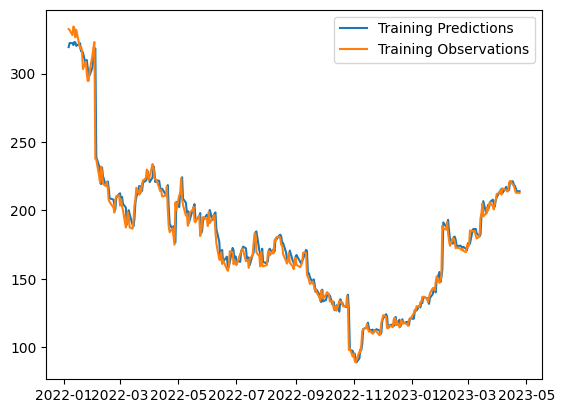

In [171]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 7ms/step


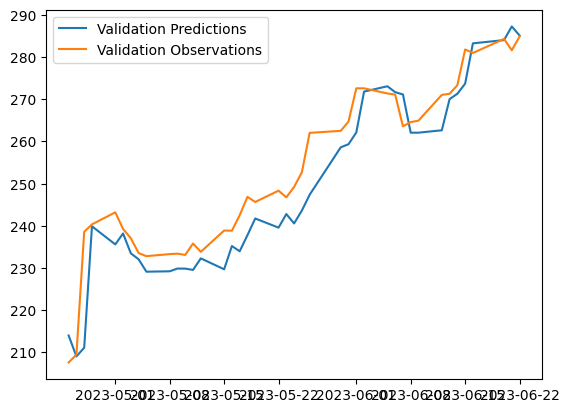

In [172]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 12ms/step


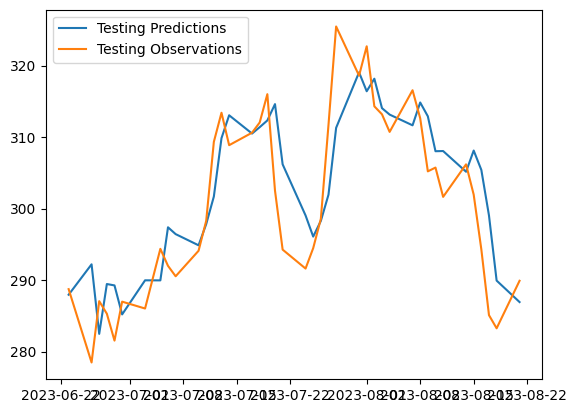

In [173]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

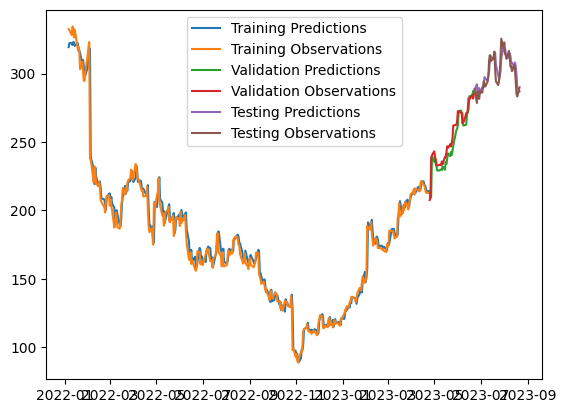

In [174]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])